In [177]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *                                                                                                                                                                                                                                           

In [178]:
heat_df = pd.read_csv('data/utilities.csv', usecols = ['temp','ccf'])

heat_df = heat_df.loc[~(((heat_df['temp'] == 60) & (heat_df['ccf']==129)) | 
                        ((heat_df['temp'] == 41) & (heat_df['ccf']==16))), :]

y = heat_df['ccf']
X = heat_df[['temp']]

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Train-Test Split

Although we want to use all of our data in building a model, we also want to get a sense of how
the model behaves with new data. We often do not have the luxury of collecting additional data to assess a model, so instead we set aside a portion of our data, called the *test set*, to stand in for new data. The remainder of the data is called the *train set*, and we use this portion to build the model. Then, after we have chosen a model, we pull out the test set and see how well the model (fitted on the train set) predicts the outcomes in the test set. {numref}`Figure %s <train-test-diagram>` demonstrates this idea. 

```{figure} figures/TrainTestDiagram.png
---
name: train-test-diagram
---

The train-test split divides the data into two parts: the train set is used to build the model and the test set evaluates that model 
```

Typically, the test set consists of 10\% to 25\% of the data.  What might not be clear from the diagram is that this division into two parts is often made at random, so the train and test sets are similar to each other. 

We can describe this process using the notion introduced in {numref}`Chapter %s <ch:linear>`. 
The design matrix, $ \textbf{X} $, and outcome, $ \mathbf{y} $, are each divided into two parts; the  design matrix, labeled $ \textbf{X}_T $, and corresponding outcomes, $ \mathbf{y}_T $, form the train set. We minimize the average squared loss over $\boldsymbol{\theta}$ with these data:  

$$
\min_{\boldsymbol{\theta}} \lVert \mathbf{y}_T - {\textbf{X}_T}{\boldsymbol{{\theta}}} \rVert^2
$$

The coefficient, $\boldsymbol{\hat{\theta}}_T$, that minimizes the training error is used to predict outcomes for the test set, which is labeled $ \textbf{X}_S $ and $ \mathbf{y}_S $: 

$$
\lVert \mathbf{y}_S - {\textbf{X}_S}{\boldsymbol{\hat{\theta}}_T} \rVert^2
$$

Since  $ \textbf{X}_S $ and $ \mathbf{y}_S $ are not used to build the model, they give a reasonable estimate of the loss we might expect for a new observation. 

We demonstrate the train-test split with our polynomial model for gas consumption from the previous section.
To do this, we carry out the following steps:

1. Split the data at random into two parts, the train and test sets.
2. Fit several polynomial models to the train set and choose one.
3. Compute the MSE on the test set for the chosen polynomial (with coefficients fitted on the train set). 

For the first step, we divide the data with the `train_test_split` method in `scikit-learn` and set aside 22 observations for model evaluation:

In [180]:
from sklearn.model_selection import train_test_split

test_size = 22

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42)


print(f'Training set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

Training set size: 75
Test set size: 22


As in the previous section, we fit models of gas consumption to various polynomials in temperature. But this time, we use only the training data: 

In [181]:
poly = PolynomialFeatures(degree=12, include_bias=False)
poly_train = poly.fit_transform(X_train)

degree = np.arange(1,13)

mods = [LinearRegression().fit(poly_train[:, :j], y_train)
        for j in degree]

We find the MSE for each of these models:

In [183]:
from sklearn.metrics import mean_squared_error

error_train = [
    mean_squared_error(y_train, mods[j].predict(poly_train[:, : (j + 1)]))
    for j in range(12)
]

To visualize the change in MSE, we plot MSE for each fitted polynomial against its degree:

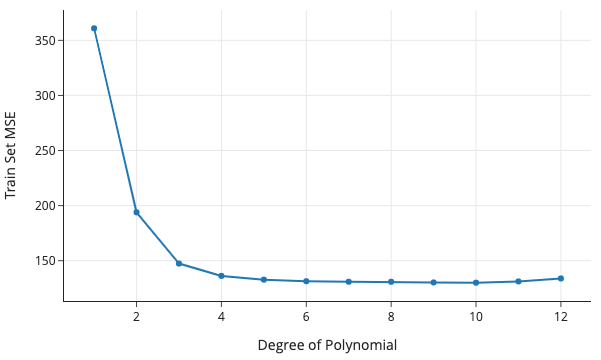

In [184]:
px.line(x=degree, y=error_train, markers=True,
        labels=dict(x='Degree of Polynomial', y='Train Set MSE'),
        width=350, height=250)

Notice that the training error decreases with the additional model complexity.
We saw earlier that the higher-order polynomials showed a wiggly behavior that
we don't think reflects the underlying structure in the data. With this in
mind, we might choose a model that is simpler but shows a large reduction in
MSE. That could be degree 3, 4, or 5. Let's go with degree 3 since the
difference between these three models in terms of MSE is quite small and it's
the simplest. 

Now that we have chosen our model, we provide an independent assessment of its MSE using the test set. We prepare the design matrix for the test set and use the degree 3 polynomial fitted on the train set to predict the outcome for each row in the test set. Lastly, we compute the MSE for the test set:

In [185]:
poly_test = poly.fit_transform(X_test)
y_hat = mods[2].predict(poly_test[:, :3])

mean_squared_error(y_test, y_hat)

307.44460133991674

The MSE for this model is quite a bit larger than the MSE computed on the training data. 
This demonstrates the problem with using the same data to fit and evaluate a model: the MSE doesn't adequately reflect the MSE for a new observation. To further demonstrate the problem with overfitting, we compute the error for the test for each of these models: 

In [186]:
error_test = [
    mean_squared_error(y_test, mods[j].predict(poly_test[:, : (j + 1)]))
    for j in range(12)
]

In practice, we do not look at the test set until we have committed to a model. Alternating between fitting a model on the train set and evaluating it on the test set can lead to overfitting. But for demonstration purposes, we plot the MSE on the test set for all of the polynomial models we fitted: 

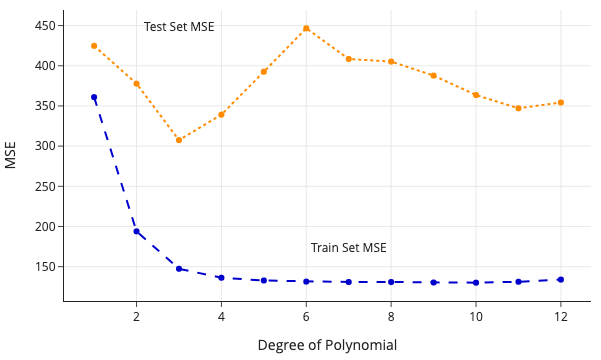

In [187]:
degree = np.arange(1, 13)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=degree,
        y=error_test,
        line=dict(color="DarkOrange", width=2, dash="dot"),
    )
)

fig.add_trace(
    go.Scatter(
        x=degree,
        y=error_train,
        line=dict(color="MediumBlue", width=2, dash="dash"),
    )
)

fig.add_annotation(x=3, y=450, showarrow=False, text="Test Set MSE")

fig.add_annotation(x=7, y=175, showarrow=False, text="Train Set MSE")

fig.update_layout(
    showlegend=False,
    width=350,
    height=250,
    xaxis_title="Degree of Polynomial",
    yaxis_title="MSE",
)

fig.show()

Notice how the MSE for the test set is larger than the MSE for the train set for all models, not just the model that we selected.  More importantly, notice how the MSE for the test set initially decreases as the model goes from underfitting to one that follows the curvature in the data a bit better. Then, as the model grows in complexity, the MSE for the test set increases. These more complex models overfit the training data and lead to large errors in predicting the test set. An idealization of this phenomenon is captured in the diagram in {numref}`Figure %s <train-test-overfit>`.    

```{figure} figures/train-test-overfitting.png
---
name: train-test-overfit
width: 350px
---

As the model grows in complexity, the train set error shrinks and the test set error increases
```

The test data provides an assessment of the prediction error for new observations.  It is crucial to use the test set only once, after we have committed to a model. Otherwise, we fall into the trap of using the same data to choose and evaluate the model. When choosing the model, we fell back on the simplicity argument because we were aware that increasingly complex models tend to overfit. However, we can extend the train-test method to help select the model as well. This is the topic of the next section. 